# run all stats for one month
## test on sample of 100 subreddits first

"""BASIC STATS
1) num comments
2) num authors
"""

"""subreddit level stats for part 1
+) number of author comments *
1) number of author subreddits *
2) author subreddit entropy *
3) author in-subreddit ratio *
4) entropy of author comment dsitribtuion
5) gini coefficient of author comment distribution

* get descriptive stats for measure: - count, mean, standard deviation, median, IQR, min, max (7)

"""

"""INPUT DATA
pulled for bigquery
in format:
author, subreddit, num_comments, (maybe also total_score)
"""

"""OUTPUT DATA
SxM dataframe where,
S = number of subreddits commented in that month
M = number of measures (including descriptives = 34?)
"""


In [53]:
from tools import *
import scipy as sp
from scipy import stats
import time

In [54]:
start_time = time.time()
df = fetchQuery("""SELECT *
FROM `author-subreddit-counts.2018.01` 
""")

copy = df.copy()

,author,subreddit,num_comments,total_score
0,kinema,depression,40,97
1,stats-i,AskOuija,16,45
2,kvg9,ethtrader,98,682
3,JanDaBan,lifeisstrange,13,43
4,texasflagemoji,houston,29,318


In [55]:
# author level
author_stats = pd.DataFrame({'author_total_subreddits':df.groupby('author')['subreddit'].count(),
                             'author_total_comments':df.groupby('author')['num_comments'].sum(),
                             'author_comment_entropy':df.groupby('author')['num_comments'].apply(
                                lambda x: stats.entropy(x))
                            })

In [56]:
"""subreddit level stats for part 1
1) number of author subreddits *
2) author subreddit entropy *
3) author in-subreddit ratio *
4) entropy of author comment dsitribtuion
5) gini coefficient of author comment distribution

* get descriptive stats for measure: - Mean, standard deviation, median, IQR, min, max
"""

# subreddit level
copy = copy.merge(author_stats, left_on='author', right_index=True)
copy['author_insubreddit_ratio']=copy['num_comments']/copy['author_total_comments']

In [57]:
num_author_subreddits = copy.groupby('subreddit')['author_total_subreddits'].describe()
num_author_comments = copy.groupby('subreddit')['author_total_comments'].describe()

num_author_subreddits.columns = pd.MultiIndex.from_product([['num_author_subreddits'], num_author_subreddits.columns])
num_author_comments.columns = pd.MultiIndex.from_product([['num_author_comments'], num_author_comments.columns])


results_filename = "full_subreddit_stats_results.csv"
results = pd.merge(num_author_comments, num_author_subreddits, left_index=True, right_index=True)
results.to_csv(results_filename) # need to cache better

In [58]:
author_subreddit_entropy = copy.groupby('subreddit')['author_comment_entropy'].describe()
author_subreddit_entropy.columns = pd.MultiIndex.from_product([['author_subreddit_entropy'], author_subreddit_entropy.columns])

results = results.merge(author_subreddit_entropy, left_index=True, right_index=True)
results.to_csv(results_filename) # need to cache better

In [59]:
author_insubreddit_ratio = copy.groupby('subreddit')['author_insubreddit_ratio'].describe()
author_insubreddit_ratio.columns = pd.MultiIndex.from_product([['author_insubreddit_ratio'], author_insubreddit_ratio.columns])

results = results.merge(author_insubreddit_ratio, left_index=True, right_index=True)
results.to_csv(results_filename) # need to cache better

In [60]:
results["subreddit_author_entropy"] = copy.groupby('subreddit')['num_comments'].apply(lambda x: stats.entropy(x))
results["subreddit_author_gini"] = copy.groupby('subreddit')['num_comments'].apply(lambda x: gini(list(x)))

results.to_csv(results_filename) # need to cache better

In [61]:
results['subreddit_author_count'] = copy.groupby('subreddit')['author'].count()
results['subreddit_comment_count'] = df.groupby('subreddit')['num_comments'].sum()

results.to_csv(results_filename) # need to cache better

In [62]:
end_time = time.time()

print("that took", end_time-start_time, "seconds to run")

that took 2602.621290206909 seconds to run


In [63]:
results.shape

(102304, 36)

## FOR JAN 2018 DATA

data sample of 10000 author-subreddit pairs took 25 seconds to run /  ~3000 subbreddits

data sample of 100000 author-subreddit pairs took 92 seconds to run / 12188 subreddits

1,000,000 took 348 seconds, for 34,224 subreddits

There are 17,403,628 rows in the full dataset, took 2602 seconds / 43 min / returned all 102,304 subreddits / 37 MB

# Interpretation of Results

In [2]:
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def mainStats(results):
    main = results[['subreddit_comment_count', 'subreddit_author_count', 'subreddit_author_entropy', 'subreddit_author_gini']]
    main.columns = main.columns.droplevel(1)
    measures = ['author_insubreddit_ratio', 'author_subreddit_entropy', 'num_author_comments', 'num_author_subreddits']
    sub = results[measures]
    sub.columns = sub.columns.droplevel()
    medians = sub['50%']
    medians.columns = measures
    main = main.merge(medians, left_index=True, right_index=True)
    
    return main

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource, output_file
from bokeh.models import NumeralTickFormatter
from bokeh.models import HoverTool


"""PLOTTING"""
#output_notebook(hide_banner=True)
output_file('scatter.html')

def scatterplot(df, x, y):
    source = ColumnDataSource(data=dict(
        x=df[x],
        y=df[y],
        subreddit=df.index,
        default = df['default'],
        col = df['default'].map({True:'red',False:'blue'})
    ))

    TOOLTIPS = [
        
    ]

    
    
    hover = HoverTool()

    hover.tooltips = [
        ("subreddit", "@subreddit"),
        (x, "@x"),
        (y, "@y"),
        ("default", "@default")
    ]
    
    p = figure(plot_width=400, plot_height=400, tools=[hover])

    p.circle('x', 'y', size=5, source=source, color='col')

    p.tools.append(hover)

    p.xaxis.axis_label = x
    p.yaxis.axis_label = y

    p.xaxis[0].formatter = NumeralTickFormatter(format="0")
    p.yaxis[0].formatter = NumeralTickFormatter(format="0")

    show(p)


def correlationHeatmap(df, date, save=False):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(date)
    plt.tight_layout()
    if save:
        plt.savefig('{}-corr-heatmap.pdf'.format(date))

In [7]:
import pandas as pd
import analysis

results_filename = "full_subreddit_stats_results.csv"
results = pd.read_csv(results_filename, index_col=0, header=[0,1])
main = mainStats(results)

date = '2018-01'

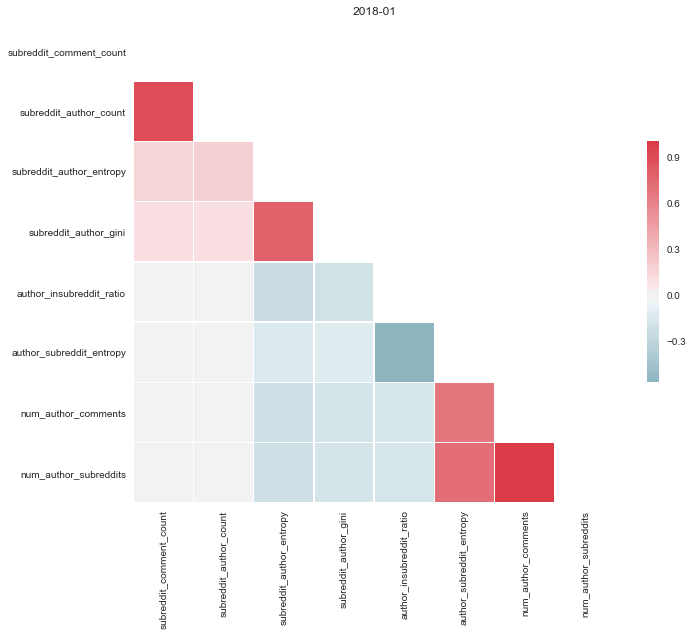

In [12]:
%matplotlib inline

sns.set(style="white")      
correlationHeatmap(main, date)

# Linear Regression of Highly Correlated Measures

In [13]:
def addDefaults(df):
    defaults = """Art+AskReddit+DIY+Documentaries+EarthPorn+Futurology+GetMotivated+IAmA+InternetIsBeautiful+Jokes+\
LifeProTips+Music+OldSchoolCool+Showerthoughts+TwoXChromosomes+UpliftingNews+WritingPrompts+\
announcements+askscience+aww+blog+books+creepy+dataisbeautiful+explainlikeimfive+food+funny+\
gadgets+gaming+gifs+history+listentothis+mildlyinteresting+movies+news+nosleep+nottheonion+\
personalfinance+philosophy+photoshopbattles+pics+science+space+sports+television+tifu+\
todayilearned+videos+worldnews""".split('+')
    df['default'] = df.index.map(lambda x: True if x in defaults else False)
    
    return df

def dropSubreddits(data, homepages=True, defaults=True):
    """takes dataframe data where index is subreddit names"""
    subset = data.copy()
    
    if homepages:
        subset = subset[~subset.index.str.startswith('u_')]
        
    if defaults:
        if 'default' not in subset.columns:
            subset = addDefaults(subset)
        subset = subset[subset['default']==False]
        
    return subset

main = addDefaults(main)
subset = dropSubreddits(main, defaults=False)

In [14]:
subset.head()

,subreddit_comment_count,subreddit_author_count,subreddit_author_entropy,subreddit_author_gini,author_insubreddit_ratio,author_subreddit_entropy,num_author_comments,num_author_subreddits,default
subreddit,,,,,,,,,
000800991021,1,1,0.000000,0.0,0.016393,0.959117,61.0,6.0,False
007,3,3,1.098612,0.0,0.250000,1.039721,4.0,4.0,False
00Ruthless,1,1,0.000000,0.0,0.000077,3.915244,12937.0,703.0,False
00sRock,2,2,0.693147,0.0,0.004808,4.492431,3275401.5,20244.5,False
00scartoons,3,3,1.098612,0.0,0.500000,0.693147,2.0,2.0,False


In [16]:
from scipy.stats import ttest_ind

def runTtest(df):
    variables = df.columns.drop('default')
    ttest = {}
    for variable in variables:
        data1 = df[df['default']==True][variable]
        data2 = df[df['default']==False][variable]

        stat, p = ttest_ind(data1, data2)
        ttest[variable] = {'t':stat,'p':p}

    ttest_results = pd.DataFrame(ttest).T.sort_values('p')
    ttest_results['accepted'] = ttest_results['p'].map(lambda x: True if x <0.01 else False)
    
    return ttest_results

In [17]:
ttest_results = runTtest(subset)
ttest_results

,p,t,accepted
subreddit_comment_count,0.000000e+00,88.696984,True
subreddit_author_count,0.000000e+00,164.886154,True
subreddit_author_entropy,5.727972e-156,26.661473,True
subreddit_author_gini,8.291211e-33,11.934647,True
author_insubreddit_ratio,1.183479e-04,-3.849701,True
num_author_subreddits,7.455508e-02,-1.783214,False
num_author_comments,8.667982e-02,-1.713198,False
author_subreddit_entropy,5.972807e-01,0.528317,False


In [158]:
import statsmodels.api as sm

subset = main.drop(index='AskReddit')
subset = subset[subset['default']==False]
X = subset["subreddit_author_count"]
y = subset['subreddit_comment_count']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     subreddit_comment_count   R-squared:                       0.691
Model:                                 OLS   Adj. R-squared:                  0.691
Method:                      Least Squares   F-statistic:                 2.286e+05
Date:                     Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                             16:30:52   Log-Likelihood:            -1.0460e+06
No. Observations:                   102255   AIC:                         2.092e+06
Df Residuals:                       102254   BIC:                         2.092e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
subreddit_author_count     7.4871      0.016    478.130      0.000       7.456       7.518
==============================================================================
Omnibus:                   297620.213   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      86727159614.588
Skew:                          39.722   Prob(JB):                         0.00
Kurtosis:                    4514.008   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

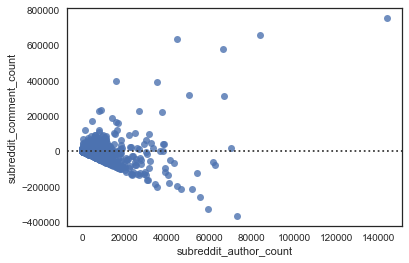

In [34]:
sns.residplot('subreddit_author_count','subreddit_comment_count', data=subset[subset['default']==False]);

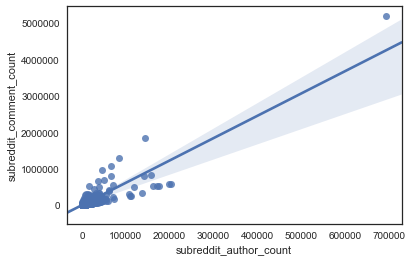

In [35]:
sns.regplot('subreddit_author_count','subreddit_comment_count', data=subset)

In [30]:
scatterplot(subset, 'subreddit_author_count', 'subreddit_comment_count')